In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import pynwb
import graph
from tqdm import tqdm
from pathlib import Path 

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import f
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Utility Functions

In [3]:
import collections

def movmean(A, w):
    """
    Calculates the moving mean of a matrix or vector horizontally.

    Args:
        A (np.array): The input matrix or vector. It must be <= 2 dimensions.
        w (int or list or ndarray): The window size for calculating the moving mean.
            If it is an integer, it calculates a centered window of size w around each element.
            If it is a 2-element list or ndarray, it calculates the window w1 elements before and w2 elements after.

    Returns:
        np.array: The moving mean of the input matrix or vector.
    """

    if A.ndim > 2:
        print("Error: input matrix cannot exceed 2 dimensions")
    elif A.ndim <= 1:
        A = A.reshape(1, -1)
    n = A.shape[1]
    if isinstance(w, (collections.abc.Sequence, np.ndarray)):
        params = [w[0], w[1]]
    else:
        params = [w, w]

    weight_matrix = np.tril(np.triu((np.ones([n, n])), -params[1]), params[0])
    return np.dot(A, weight_matrix)/weight_matrix.sum(axis=0)


from matplotlib.colors import LinearSegmentedColormap
def interpolate_colors(color1, color2, num_colors):
    """
    Interpolates a list of colors between two given colors.

    Parameters:
    color1 (str or tuple): The starting color, can be a name or an RGB tuple.
    color2 (str or tuple): The ending color, can be a name or an RGB tuple.
    num_colors (int): The number of colors to generate between color1 and color2.

    Returns:
    list: A list of interpolated colors in RGBA format.
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=num_colors)
    colors = [cmap(i) for i in range(num_colors)]
    return colors


def xy(node, nrows, ncols):
    """
    Transforms the node identity into X, y coordinates
    :param node: (int) node ID
    :param nrows: (int) number of rows
    :param ncols: (int) number of columns
    :return: (X, Y): (tuple) pair of XY coords
    """
    X = int(node % nrows)
    Y = int(np.floor(node / ncols))
    return X, Y

In [4]:
c1 = "#fc0303" # red
c2 = "#d000ff" # purple
c3 = "#0800ff" # blue
c4 = "#03b6fc" # cyan

caxis_1 = interpolate_colors(c1, c2, 4)
caxis_2 = interpolate_colors(c3, c4, 4)
cmap_2d = np.array([interpolate_colors(caxis_1[i], caxis_2[i], 4) for i in range(4)])

In [5]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [6]:
def get_spike_table(nwbfile, region, epoch, unitNumber=[], query="", window_size=0, unit_params = {"drift": 2, "min_fr": 1}):
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"
    
    unitNames = nwbfile.units.to_dataframe()
    
    if len(unitNumber)==0:
        # get all good units
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    else:
        # get a specific unit
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) 
                            & (unitNames.fr >= unit_params["min_fr"]) & (unitNames.unitNumber==unitNumber))[0]
        
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)
        
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
    
    epoch_win_size = df["window_size"].values[0]
    sample_index = df.index
    spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
    print("Building Spike Table")
    if window_size != 0:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            sample_data = movmean(sample_data.T, window_size).T
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    else:
        for i, _sample in tqdm(enumerate(sample_index)):
            sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
            spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
            
    df = graph.append_use_tele(df)
    
    return spikes, df, unitNames

In [7]:
def combine_data(DATA_DIR,region,epoch,query):
    
    # combine all sessions

    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb') # sorted()
        
    df = pd.DataFrame()
    spikes = [[] for i in range(len(filenames))]
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):

        print(filename)
        date = filename[-10:-4]
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, region, epoch, query = query, window_size = 0)
        
        temp_df.insert(0,'Session',date)
        df = pd.concat([df,temp_df]).reset_index(drop=True)
        spikes[ii] = temp_spikes
    
        unitNames.insert(0,'Session',date)
        neuron_df = pd.concat([neuron_df,unitNames]).reset_index(drop=True)

    df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
    df['postnode'] = np.insert(df.node.values[1:], -1, -1)
    df.loc[df.step==0,'prenode'] = -1
    df.loc[df.step==df.nsteps,'postnode'] = -1
    
    return df, spikes, neuron_df

In [8]:
def to_one_hot(vector):
    # Get the unique classes in the vector
    unique_classes = np.unique(vector)
    
    # Create a zero matrix of shape (len(vector), len(unique_classes))
    one_hot_matrix = np.zeros((len(vector), len(unique_classes)), dtype=int)
    
    # Map each value in the vector to its corresponding index in the one-hot matrix
    for i, value in enumerate(vector):
        one_hot_matrix[i, np.where(unique_classes == value)[0][0]] = 1

    return one_hot_matrix


In [9]:
def get_action(prenode,node):
    
    x1, y1 = xy(prenode, 4, 4)
    x2, y2 = xy(node, 4, 4)

    if prenode==-1:
        
        action = -1
        
    else:

        if x1 == x2:
            if y2-y1 == 1:
                action = 0
            if y2-y1 == -1:
                action = 1
                
        if y1 == y2:
            if x2-x1 == 1:
                action = 2
            if x2-x1 == -1:
                action = 3
    
        if (prenode==0) & (node==15):
            action = 4
    
        if (prenode==15) & (node==0):
            action = 5

    return action

In [10]:
def create_balanced_datasets(df,FR,var1,var2,trialNum=100):
    
    bstrap_df = pd.DataFrame()
    bstrap_spikes = []
    
    for var1_ind,val1 in enumerate(np.unique(df[var1])):  
        for var2_ind,val2 in enumerate(np.unique(df[var2])):
    
            condition_idx = (df[var1]==val1) & (df[var2]==val2)
            temp_df = df[condition_idx].reset_index(drop=True)  
            temp_FR = FR[condition_idx,:,:]
    
            if len(temp_df)>10:
                
                idx = np.random.randint(len(temp_df),size=trialNum)
                bstrap_df = pd.concat([bstrap_df,temp_df.loc[idx,:]])
                bstrap_spikes.append(temp_FR[idx,:,:])

    return bstrap_df, np.concatenate(bstrap_spikes)

In [20]:
DATA_DIR = Path('/Volumes/Extreme SSD')
FIG_DIR = Path('/Users/lianghexin/Documents/Berkeley/Teleworld/Figures')

In [244]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,"HPC","action_on","trialerror == 0")
choice_df["action"] = choice_df.apply(lambda row: get_action(row['prenode'],row['node']), axis=1)
choice_df['distance']=choice_df['graph_distance']
choice_df.loc[choice_df.distance>3,'distance'] = 4

In [19]:
neuron_df = pd.read_hdf("/Volumes/Extreme SSD/SingleNeurons.h5", key="data")

Bart_TeleWorld_v13_031723.nwb
Building Spike Table


1499it [00:00, 1658.85it/s]


Building Spike Table


1499it [00:00, 1995.09it/s]


Building Spike Table


1499it [00:00, 1809.92it/s]


Building Spike Table


1499it [00:00, 1924.85it/s]


Building Spike Table


1499it [00:00, 1766.90it/s]


Building Spike Table


1499it [00:00, 1903.17it/s]


Building Spike Table


1499it [00:00, 1964.83it/s]


Building Spike Table


1499it [00:00, 1908.20it/s]


Building Spike Table


1499it [00:00, 1914.28it/s]


Building Spike Table


1499it [00:00, 1968.01it/s]


Building Spike Table


1499it [00:00, 1877.56it/s]


Bart_TeleWorld_v13_032823.nwb
Building Spike Table


1860it [00:01, 1607.77it/s]


Building Spike Table


1860it [00:01, 1651.95it/s]


Building Spike Table


1860it [00:00, 1906.20it/s]


Building Spike Table


1860it [00:00, 1895.64it/s]


Building Spike Table


1860it [00:00, 1904.08it/s]


Building Spike Table


1860it [00:00, 1879.41it/s]


Building Spike Table


1860it [00:00, 1912.16it/s]


Building Spike Table


1860it [00:00, 1885.02it/s]


Building Spike Table


1860it [00:00, 1881.68it/s]


Building Spike Table


1860it [00:00, 1896.23it/s]


Building Spike Table


1860it [00:00, 1900.82it/s]


Building Spike Table


1860it [00:00, 2018.35it/s]


Building Spike Table


1860it [00:00, 1903.55it/s]


Building Spike Table


1860it [00:00, 1900.15it/s]


Building Spike Table


1860it [00:00, 1900.54it/s]


Building Spike Table


1860it [00:00, 1904.55it/s]


Building Spike Table


1860it [00:00, 1900.32it/s]


Building Spike Table


1860it [00:01, 1812.35it/s]


Building Spike Table


1860it [00:00, 1917.75it/s]


Building Spike Table


1860it [00:01, 1818.28it/s]


Building Spike Table


1860it [00:00, 1867.12it/s]


Building Spike Table


1860it [00:01, 1824.00it/s]


Building Spike Table


1860it [00:01, 1810.56it/s]


Building Spike Table


1860it [00:00, 1915.44it/s]


Building Spike Table


1860it [00:01, 1819.66it/s]


Bart_TeleWorld_v13_033123.nwb
Building Spike Table


2067it [00:01, 1732.74it/s]


Building Spike Table


2067it [00:00, 2088.21it/s]


Building Spike Table


2067it [00:01, 2034.48it/s]


Building Spike Table


2067it [00:00, 2094.35it/s]


Building Spike Table


2067it [00:01, 2062.91it/s]


Building Spike Table


2067it [00:00, 2264.42it/s]


Building Spike Table


2067it [00:01, 1791.68it/s]


Building Spike Table


2067it [00:00, 2104.03it/s]


Building Spike Table


2067it [00:00, 2135.39it/s]


Building Spike Table


2067it [00:01, 2036.23it/s]


Building Spike Table


2067it [00:00, 2083.12it/s]


Building Spike Table


2067it [00:00, 2775.82it/s]


Building Spike Table


2067it [00:00, 2771.35it/s]


Building Spike Table


2067it [00:00, 2823.98it/s]


Building Spike Table


2067it [00:00, 2767.55it/s]


Building Spike Table


2067it [00:00, 2802.05it/s]


Building Spike Table


2067it [00:00, 2738.27it/s]


Building Spike Table


2067it [00:00, 2456.03it/s]


Building Spike Table


2067it [00:00, 2716.64it/s]


Bart_TeleWorld_v13_032023.nwb
Building Spike Table


2278it [00:01, 1836.82it/s]


Building Spike Table


2278it [00:01, 2179.61it/s]


Building Spike Table


2278it [00:01, 2142.41it/s]


Building Spike Table


2278it [00:01, 2176.39it/s]


Building Spike Table


2278it [00:01, 2172.07it/s]


Building Spike Table


2278it [00:01, 2127.53it/s]


Building Spike Table


2278it [00:01, 2163.71it/s]


Building Spike Table


2278it [00:01, 2234.05it/s]


Building Spike Table


2278it [00:01, 2248.48it/s]


Building Spike Table


2278it [00:01, 2216.02it/s]


Bart_TeleWorld_v13_040423.nwb
Building Spike Table


2452it [00:01, 1629.55it/s]


Building Spike Table


2452it [00:01, 1953.67it/s]


Building Spike Table


2452it [00:01, 1906.63it/s]


Building Spike Table


2452it [00:01, 1956.09it/s]


Building Spike Table


2452it [00:01, 1962.41it/s]


Building Spike Table


2452it [00:01, 1705.25it/s]


Building Spike Table


2452it [00:01, 1910.22it/s]


Bart_TeleWorld_v13_040723.nwb
Building Spike Table


2093it [00:01, 1868.62it/s]


Building Spike Table


2093it [00:00, 2245.00it/s]


Building Spike Table


2093it [00:00, 2233.68it/s]


Building Spike Table


2093it [00:00, 2273.48it/s]


Building Spike Table


2093it [00:00, 2205.06it/s]


Building Spike Table


2093it [00:00, 2228.25it/s]


Building Spike Table


2093it [00:00, 2232.28it/s]


Building Spike Table


2093it [00:00, 2266.73it/s]


Building Spike Table


2093it [00:00, 2257.94it/s]


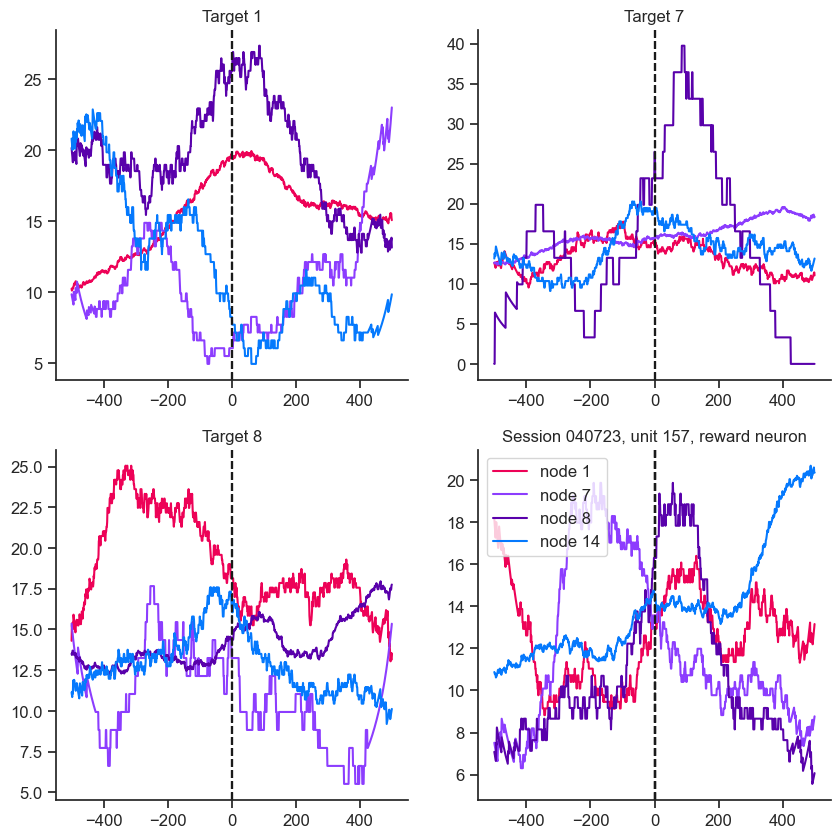

In [52]:
# plot value neurons / reward neurons

os.chdir(DATA_DIR)
filenames = glob.glob('*.nwb') # sorted()
    
df = pd.DataFrame()
spikes = [[] for i in range(len(filenames))]

for ii, filename in enumerate(filenames):

    print(filename)
    date = filename[-10:-4]
    
    nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
    unitNumbers = neuron_df.query("reward & (Session==@date)").unitNumber.values

    for unitNumber in unitNumbers:
        temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, 'HPC', "action_on", unitNumber,'trialerror==0', window_size=0)
        plot_psth(temp_spikes, temp_df, unitNumber,date)

Bart_TeleWorld_v13_031723.nwb
Bart_TeleWorld_v13_032823.nwb
Building Spike Table


1860it [00:01, 1598.87it/s]


Building Spike Table


1860it [00:01, 1677.69it/s]


Bart_TeleWorld_v13_033123.nwb
Bart_TeleWorld_v13_032023.nwb
Bart_TeleWorld_v13_040423.nwb
Bart_TeleWorld_v13_040723.nwb


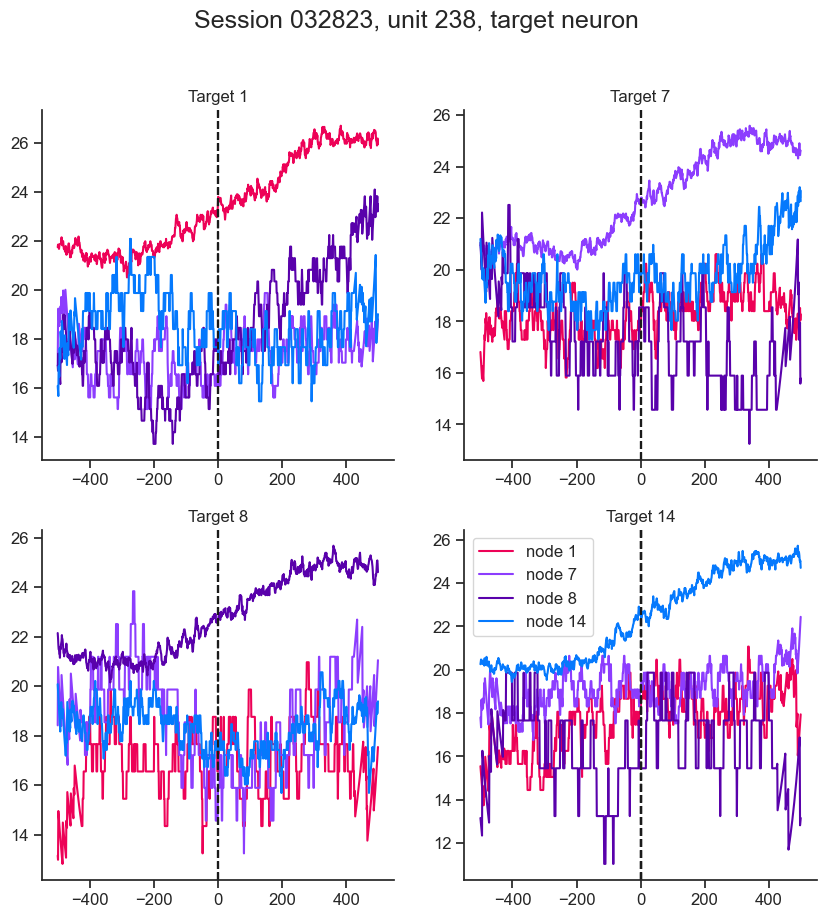

In [62]:
# plot value neurons / target neurons

os.chdir(DATA_DIR)
filenames = glob.glob('*.nwb') # sorted()
    
df = pd.DataFrame()
spikes = [[] for i in range(len(filenames))]

for ii, filename in enumerate(filenames):

    print(filename)
    date = filename[-10:-4]

    if date=='032823':
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        unitNumbers = neuron_df.query("target & (Session==@date)").unitNumber.values
    
        for unitNumber in [179,238]:#unitNumbers:
            temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, 'HPC', "action_on", unitNumber,'trialerror==0', window_size=0)
            plot_psth(temp_spikes, temp_df, unitNumber,date)

In [60]:
def plot_psth(spikes, df, unitNumber, date):

    plt.close('all')
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    for ii, target in enumerate([1,7,8,14]):
    
        r,c = np.divmod(ii,2)
    
        for node in [1,7,8,14]:
        
            x, y = xy(node, 4, 4)            
    
            t = np.arange(-500, 500)
            
            idx = (df.node.values==node) & (df.target.values==target)
            spikes_choices = temp_spikes[idx, :,0]
            trace = movmean(np.nanmean(spikes_choices,axis=0)*1000, w=75).flatten()
            
            ax[r,c].plot(t, trace, c= cmap_2d[x, y], label='node %i' % node)
            ax[r,c].axvline(0, color='k', linestyle='--')
            ax[r,c].set_title('Target %i' % target)
    
            if ii==3:
                ax[r,c].legend()
            
        plt.axvline(0, color='k', linestyle='--')
    plt.suptitle("Session %s, unit %i, target neuron" % (date,unitNumber))
    plt.savefig("Session %s, unit %i, target neuron" % (date,unitNumber))

Bart_TeleWorld_v13_031723.nwb
Building Spike Table


1499it [00:00, 1706.29it/s]


Building Spike Table


1499it [00:00, 1789.36it/s]


Building Spike Table


1499it [00:00, 1971.95it/s]


Building Spike Table


1499it [00:00, 1974.05it/s]


Building Spike Table


1499it [00:00, 1994.00it/s]


Building Spike Table


1499it [00:00, 1792.81it/s]


Building Spike Table


1499it [00:00, 1942.55it/s]


Building Spike Table


1499it [00:00, 1893.97it/s]


Building Spike Table


1499it [00:00, 1933.46it/s]


Building Spike Table


1499it [00:00, 1907.34it/s]


Building Spike Table


1499it [00:00, 1933.20it/s]


Building Spike Table


1499it [00:00, 1973.37it/s]


Building Spike Table


1499it [00:00, 1926.24it/s]


Building Spike Table


1499it [00:00, 1976.62it/s]


Building Spike Table


1499it [00:00, 1947.06it/s]


Building Spike Table


1499it [00:00, 1960.98it/s]


Building Spike Table


1499it [00:00, 1791.66it/s]


Building Spike Table


1499it [00:00, 1998.96it/s]


Building Spike Table


1499it [00:00, 1917.53it/s]


Building Spike Table


1499it [00:00, 1689.87it/s]


Building Spike Table


1499it [00:00, 1986.70it/s]


Building Spike Table


1499it [00:00, 1936.23it/s]


Building Spike Table


1499it [00:00, 1994.25it/s]


Building Spike Table


1499it [00:00, 2009.99it/s]


Building Spike Table


1499it [00:00, 2001.56it/s]


Building Spike Table


1499it [00:00, 1998.18it/s]


Building Spike Table


1499it [00:00, 1980.56it/s]


Building Spike Table


1499it [00:00, 1993.56it/s]


Bart_TeleWorld_v13_032823.nwb
Building Spike Table


1860it [00:01, 1496.18it/s]


Building Spike Table


1860it [00:00, 1876.28it/s]


Building Spike Table


1860it [00:00, 1922.92it/s]


Building Spike Table


1860it [00:00, 1875.67it/s]


Building Spike Table


1860it [00:00, 1919.69it/s]


Building Spike Table


1860it [00:00, 1889.37it/s]


Building Spike Table


1860it [00:00, 1894.47it/s]


Building Spike Table


1860it [00:00, 1900.28it/s]


Building Spike Table


1860it [00:00, 1888.66it/s]


Building Spike Table


1860it [00:00, 1915.03it/s]


Building Spike Table


1860it [00:00, 1923.34it/s]


Building Spike Table


1860it [00:01, 1839.88it/s]


Building Spike Table


1860it [00:00, 1904.36it/s]


Building Spike Table


1860it [00:01, 1776.52it/s]


Building Spike Table


1860it [00:01, 1859.37it/s]


Building Spike Table


1860it [00:00, 1913.44it/s]


Building Spike Table


1860it [00:00, 1892.60it/s]


Building Spike Table


1860it [00:00, 1929.77it/s]


Building Spike Table


1860it [00:00, 1924.59it/s]


Building Spike Table


1860it [00:00, 1931.53it/s]


Building Spike Table


1860it [00:01, 1706.80it/s]


Building Spike Table


1860it [00:01, 1698.21it/s]


Building Spike Table


1860it [00:00, 1915.08it/s]


Building Spike Table


1860it [00:00, 1898.46it/s]


Building Spike Table


1860it [00:00, 2061.94it/s]


Bart_TeleWorld_v13_033123.nwb
Building Spike Table


2067it [00:01, 1750.97it/s]


Building Spike Table


2067it [00:00, 2129.69it/s]


Building Spike Table


2067it [00:00, 2141.74it/s]


Building Spike Table


2067it [00:00, 2727.18it/s]


Building Spike Table


2067it [00:00, 2979.41it/s]


Building Spike Table


2067it [00:00, 2943.96it/s]


Building Spike Table


2067it [00:00, 2913.92it/s]


Building Spike Table


2067it [00:00, 5394.74it/s]


Building Spike Table


2067it [00:00, 23067.39it/s]


Building Spike Table


2067it [00:00, 23656.61it/s]


Building Spike Table


2067it [00:00, 22277.97it/s]


Building Spike Table


2067it [00:00, 20391.44it/s]


Building Spike Table


2067it [00:00, 23353.03it/s]


Building Spike Table


2067it [00:00, 23360.46it/s]


Building Spike Table


2067it [00:00, 22542.16it/s]


Building Spike Table


2067it [00:00, 23420.98it/s]


Building Spike Table


2067it [00:00, 23202.84it/s]


Building Spike Table


2067it [00:00, 22637.64it/s]


Building Spike Table


2067it [00:00, 23649.06it/s]


Building Spike Table


2067it [00:00, 23116.72it/s]


Building Spike Table


2067it [00:00, 23969.97it/s]


Building Spike Table


2067it [00:00, 23956.85it/s]


Building Spike Table


2067it [00:00, 19655.18it/s]


Building Spike Table


2067it [00:00, 23077.46it/s]


Bart_TeleWorld_v13_032023.nwb
Building Spike Table


2278it [00:01, 1885.15it/s]


Building Spike Table


2278it [00:01, 2173.89it/s]


Building Spike Table


2278it [00:00, 2341.84it/s]


Building Spike Table


2278it [00:00, 3210.19it/s]


Building Spike Table


2278it [00:00, 3173.16it/s]


Building Spike Table


2278it [00:00, 3184.38it/s]


Building Spike Table


2278it [00:00, 3217.42it/s]


Building Spike Table


2278it [00:00, 3035.00it/s]


Building Spike Table


2278it [00:00, 2826.42it/s]


Building Spike Table


2278it [00:00, 2954.14it/s]


Building Spike Table


2278it [00:00, 2914.29it/s]


Building Spike Table


2278it [00:00, 2870.02it/s]


Building Spike Table


2278it [00:00, 3121.78it/s]


Bart_TeleWorld_v13_040423.nwb
Building Spike Table


2452it [00:01, 1606.11it/s]


Building Spike Table


2452it [00:01, 1916.20it/s]


Building Spike Table


2452it [00:01, 1953.42it/s]


Building Spike Table


2452it [00:01, 1548.39it/s]


Building Spike Table


2452it [00:01, 1973.09it/s]


Building Spike Table


2452it [00:01, 1951.77it/s]


Building Spike Table


2452it [00:00, 2598.51it/s]


Bart_TeleWorld_v13_040723.nwb
Building Spike Table


2093it [00:01, 1955.10it/s]


Building Spike Table


2093it [00:00, 2349.07it/s]


Building Spike Table


2093it [00:00, 2333.38it/s]


Building Spike Table


2093it [00:00, 2372.01it/s]


Building Spike Table


2093it [00:00, 2752.19it/s]


Building Spike Table


2093it [00:00, 2661.47it/s]


Building Spike Table


2093it [00:00, 2648.28it/s]


Building Spike Table


2093it [00:00, 2471.41it/s]


Building Spike Table


2093it [00:00, 2343.41it/s]


Building Spike Table


2093it [00:00, 5045.39it/s]


Building Spike Table


2093it [00:00, 9042.08it/s]


Building Spike Table


2093it [00:00, 21054.91it/s]


Building Spike Table


2093it [00:00, 24084.89it/s]


Building Spike Table


2093it [00:00, 24659.21it/s]


Building Spike Table


2093it [00:00, 24242.79it/s]


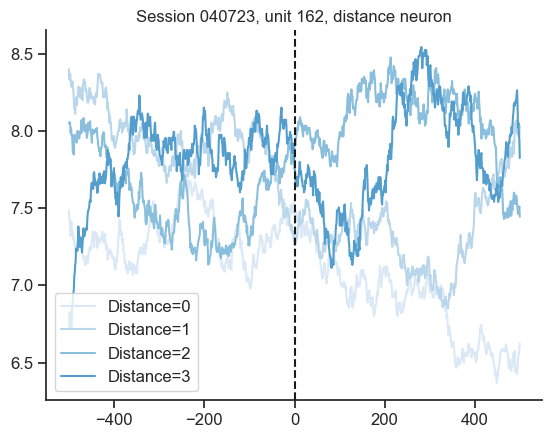

In [32]:
# plot value neurons /  distance neurons

os.chdir(DATA_DIR)
filenames = glob.glob('*.nwb') # sorted()
    
df = pd.DataFrame()
spikes = [[] for i in range(len(filenames))]

for ii, filename in enumerate(filenames):

    print(filename)
    date = filename[-10:-4]
    
    nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
    unitNumbers = neuron_df.query("distance & (Session==@date)").unitNumber.values

    for unitNumber in unitNumbers:
        temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, 'HPC', "action_on", unitNumber,'trialerror==0', window_size=0)
        plot_psth(temp_spikes, temp_df, 'graph_distance', unitNumber,date)

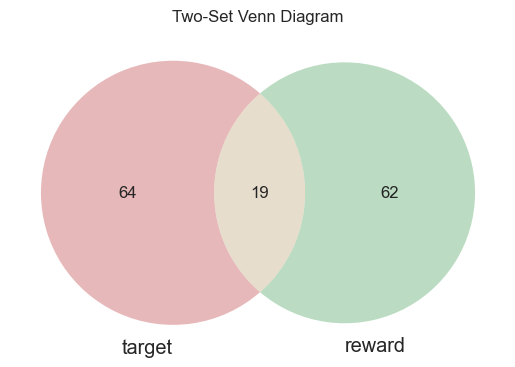

In [66]:
var1='target'
var2='reward'
AB = np.sum(neuron_df[var1].values & neuron_df[var2].values)
venn2(subsets=(np.sum(neuron_df[var1].values)-AB, np.sum(neuron_df[var2].values)-AB, AB), set_labels=(var1,var2))
plt.title("Two-Set Venn Diagram")
plt.show()

In [225]:
a = choice_df.query('Session==@date').groupby(['node','distance']).size().values

(array([0., 2., 5., 0., 5., 5., 1., 3., 0., 2., 2., 1., 0., 1., 1., 0., 2.,
        1., 1., 3., 2., 2., 0., 1., 2., 1., 0., 0., 0.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58.]),
 <BarContainer object of 29 artists>)

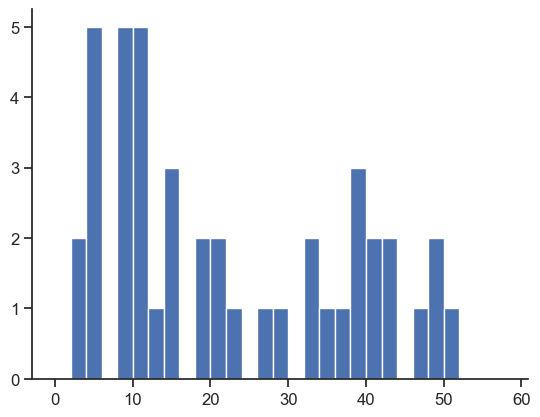

In [231]:
plt.close('all')
plt.hist(a,bins=np.arange(0,60,2))

In [195]:
# elasticnet

# regressors to build: 1) node as one hop vector, 
#                      2) distance/value, 
#                      3) action, two possible ways: one hop (N,S,W,E,tele 0->15, tele 15->0); 
#                                                      -1,1 for NS; -1,1 for WE; -1,1 for tele; 1 for tele (no direction)

ss = 0
date = '031723'
    
timestamps = np.arange(100,950,50)
unitNames = neuron_df.query("Session==@date").unitNumber.values
nn = np.where(unitNames==196)[0]

ses = choice_df.query("Session==@date")
FR = choice_spikes[ss]

one_hop_node = to_one_hot(ses['node'].values)

one_hop_action = to_one_hot(ses['action'].values)[:,1:]

NS = np.reshape(one_hop_action[:,0]-one_hop_action[:,1],(-1,1))
WE = np.reshape(one_hop_action[:,2]-one_hop_action[:,3],(-1,1))

tele_dir = np.reshape(one_hop_action[:,4]-one_hop_action[:,5],(-1,1))
tele = np.reshape(one_hop_action[:,4]+one_hop_action[:,5],(-1,1))



X = np.concatenate([one_hop_node,one_hop_action,ses['distance'].values.reshape(-1,1),
                   NS,WE,tele_dir,tele],axis=1)
predictor_names = ['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 
                     'Node 6', 'Node 7', 'Node 8', 'Node 9', 'Node 10', 'Node 11',
                     'Node 12', 'Node 13', 'Node 14', 'Node 15',
                  'left','right','up','down','0 to 15','15 to 0',
                  'distance', 'NS','WE','tele_dir','tele']

# --- Elastic Net with cross-validation ---
# l1_ratio=0.5 means equal mix of LASSO and Ridge
# (you can also search across multiple ratios)
enet_cv = make_pipeline(
    StandardScaler(),  # always scale predictors for regularized regression
    ElasticNetCV(
        l1_ratio=[0.2,0.4,0.6,0.8],  # grid search over L1/L2 mixing
        alphas=None,               # auto-selects a range of penalty strengths
        cv=10,                     # 10-fold CV
        max_iter=10000,
        n_jobs=-1,
        selection = 'random'
    )
)

enet_cv.fit(X, FR[:,500-200:500+200,nn].sum(axis=1).ravel())

# --- Results ---
elasticnet = enet_cv.named_steps['elasticnetcv']

print("Optimal alpha (regularization strength):", elasticnet.alpha_)
print("Optimal l1_ratio:", elasticnet.l1_ratio_)
print("R^2 score on training data:", elasticnet.score(X, FR[:,500-100:500+100,nn].sum(axis=1).ravel()))

# Get coefficients
coefs = elasticnet.coef_
print("Selected coefficients:")
for i, c in enumerate(coefs):
    if c != 0:
        print(f"{predictor_names[i]}: {c:.3f}")


Optimal alpha (regularization strength): 0.16316365921485868
Optimal l1_ratio: 0.2
R^2 score on training data: -0.8763102771029458
Selected coefficients:
Node 0: -0.006
Node 1: -0.000
Node 2: -0.008
Node 3: 0.004
Node 5: 0.097
Node 6: 0.064
Node 7: 0.109
Node 8: -0.022
Node 9: 0.043
Node 11: 0.068
Node 12: -0.137
Node 15: 0.028
up: -0.034
down: -0.076
0 to 15: 0.093
distance: 0.159
tele_dir: 0.025


In [201]:
# lasso with permutation
results, model = lasso_permutation_test(X, FR[:,500-200:500+200,nn].sum(axis=1).ravel(), n_permutations=50)
results.index = predictor_names
print(results.sort_values("coef"))

              coef     perm_mean  pval
Node 12  -0.737840  0.000000e+00  0.00
down     -0.223248 -2.599496e-03  0.00
up       -0.116228  3.535727e-03  0.02
Node 8   -0.045124 -7.671679e-04  0.04
Node 0   -0.000000 -1.204928e-02  1.00
WE       -0.000000 -8.574707e-03  1.00
15 to 0  -0.000000  0.000000e+00  1.00
right    -0.000000  6.688248e-17  1.00
left      0.000000 -4.432615e-03  1.00
Node 14  -0.000000  5.904138e-03  1.00
Node 13  -0.000000  1.113103e-03  1.00
Node 4   -0.000000 -2.023580e-03  1.00
Node 3    0.000000  0.000000e+00  1.00
Node 2   -0.000000  2.148513e-03  1.00
Node 1   -0.000000  5.180024e-03  1.00
Node 10  -0.000000 -4.753683e-03  1.00
0 to 15   0.011020  3.392988e-03  0.02
NS        0.023550  2.594353e-03  0.08
Node 9    0.146634  1.034415e-02  0.02
Node 15   0.151915  1.046241e-02  0.04
tele      0.166674 -2.214539e-04  0.00
distance  0.194037 -6.626577e-04  0.00
Node 6    0.242095  1.480995e-02  0.02
Node 11   0.287257 -3.661405e-03  0.00
tele_dir  0.390446  0.000

In [218]:
# CPD, F-test for all the variables 

timestamps = [300,500,700]
baseline_vars = ['distance']
candidate_vars = ['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 
                     'Node 6', 'Node 7', 'Node 8', 'Node 9', 'Node 10', 'Node 11',
                     'Node 12', 'Node 13', 'Node 14', 'Node 15',
                  'left','right','up','down','0 to 15','15 to 0',
                  'NS','WE','tele_dir','tele']
results_df = pd.DataFrame()

# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):

    print(ss,date)
    
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]

    unitNames = neuron_df.query("Session==@date").unitNumber.values
    nn = np.where(unitNames==196)[0]
    
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]
    
    one_hop_node = to_one_hot(ses['node'].values)
    one_hop_action = to_one_hot(ses['action'].values)[:,1:]
    
    WE = np.reshape(one_hop_action[:,0]-one_hop_action[:,1],(-1,1))
    NS = np.reshape(one_hop_action[:,2]-one_hop_action[:,3],(-1,1))
    
    tele_dir = np.reshape(one_hop_action[:,4]-one_hop_action[:,5],(-1,1))
    tele = np.reshape(one_hop_action[:,4]+one_hop_action[:,5],(-1,1))
    
    X = pd.DataFrame(np.concatenate([ses['distance'].values.reshape(-1,1),
                                     one_hop_node,one_hop_action,
                                     NS,WE,tele_dir,tele],axis=1),
                        columns = ['distance', 'Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 
                         'Node 6', 'Node 7', 'Node 8', 'Node 9', 'Node 10', 'Node 11',
                         'Node 12', 'Node 13', 'Node 14', 'Node 15',
                      'left','right','up','down','0 to 15','15 to 0',
                      'NS','WE','tele_dir','tele'])

    
    for nn,unitNumber in tqdm(enumerate(unitNames)):
                
        for ii, tt in enumerate(timestamps):

            y = FR[:,tt-200:tt+200,nn].sum(axis=1)
            
            results = []
            for var in candidate_vars:
                res = partial_r2_and_f(X, y, baseline_vars, [var])
                res['unitNumber']=unitNumber
                res['time']=tt
                res['Session']=date
                res['variable']=var
                results.append(res)
            
            results_df = pd.concat([results_df,pd.DataFrame(results)])
            
            # Optional: format scientific notation for p-values
            # results_df['pval_f'] = results_df['pval_f'].map(lambda x: f"{x:.2e}")
            # results_df['significant'] = results_df['pval_f'].values<0.05

0 031723


80it [00:14,  5.48it/s]


1 032823


94it [00:18,  5.14it/s]


2 033123


88it [00:16,  5.29it/s]


3 032023


73it [00:14,  5.10it/s]


4 040423


88it [00:17,  5.13it/s]


5 040723


60it [00:11,  5.00it/s]


In [219]:
results_df['significant']=results_df['pval_f'].values<0.05
results_df

,r2_partial,r2_full,r2_reduced,f_stat,pval_f,unitNumber,time,Session,variable,significant
0,0.000664,0.001603,0.000939,0.994487,0.318809,97,300,031723,Node 0,False
1,0.000014,0.000954,0.000939,0.021597,0.883184,97,300,031723,Node 1,False
2,0.000129,0.001068,0.000939,0.193309,0.660240,97,300,031723,Node 2,False
3,0.000001,0.000941,0.000939,0.001998,0.964356,97,300,031723,Node 3,False
4,0.000042,0.000981,0.000939,0.063140,0.801635,97,300,031723,Node 4,False
...,...,...,...,...,...,...,...,...,...,...
21,0.000005,0.001418,0.001414,0.009977,0.920444,167,700,040723,15 to 0,False
22,0.000104,0.001518,0.001414,0.217647,0.640887,167,700,040723,NS,False
23,0.002111,0.003522,0.001414,4.422345,0.035591,167,700,040723,WE,True
24,0.000117,0.001531,0.001414,0.244957,0.620701,167,700,040723,tele_dir,False


In [221]:
results_df.to_hdf("CPD.h5",key='data')

In [57]:
results_df = pd.read_hdf("CPD.h5", key='data')

In [51]:
presacc = results_df.query("time==300")
sacc = results_df.query("time==500")
postsacc = results_df.query("time==700")

In [163]:
candidate_vars = np.array(['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 
                     'Node 6', 'Node 7', 'Node 8', 'Node 9', 'Node 10', 'Node 11',
                     'Node 12', 'Node 13', 'Node 14', 'Node 15',
                  'left','right','up','down','0 to 15','15 to 0',
                  'NS','WE','tele_dir','tele'])

In [179]:
date='031723'
sacc.query("(Session==@date) & (unitNumber==196)").sort_values(by='r2_partial')

,r2_partial,r2_full,r2_reduced,f_stat,pval_f,unitNumber,time,Session,variable,significant
23,0.000029,0.011577,0.011549,0.042877,0.835986,196,500,031723,WE,False
3,0.000079,0.011627,0.011549,0.118492,0.730724,196,500,031723,Node 3,False
18,0.000168,0.011715,0.011549,0.250880,0.616530,196,500,031723,up,False
17,0.000217,0.011764,0.011549,0.325142,0.568619,196,500,031723,right,False
21,0.000224,0.011770,0.011549,0.335088,0.562766,196,500,031723,15 to 0,False
13,0.000271,0.011817,0.011549,0.406111,0.524047,196,500,031723,Node 13,False
16,0.000483,0.012027,0.011549,0.723250,0.395216,196,500,031723,left,False
4,0.000500,0.012043,0.011549,0.748543,0.387077,196,500,031723,Node 4,False
10,0.000544,0.012086,0.011549,0.813756,0.367157,196,500,031723,Node 10,False
14,0.000603,0.012145,0.011549,0.902722,0.342206,196,500,031723,Node 14,False


['Node 9' 'Node 2' '15 to 0' 'tele' 'Node 7' 'Node 14' 'Node 13' 'NS'
 'Node 8' 'Node 5' '0 to 15' 'Node 4' 'tele_dir' 'Node 12' 'Node 11'
 'Node 15' 'Node 6' 'Node 10' 'Node 3' 'left' 'up' 'WE' 'Node 0' 'Node 1'
 'right' 'down']


(array([25., 33.,  8., 21., 15., 13., 19., 11., 12.,  7., 21., 16., 16.,
        11., 11., 19., 22., 41., 24., 55., 13.,  9., 12., 24., 15., 10.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5]),
 <BarContainer object of 26 artists>)

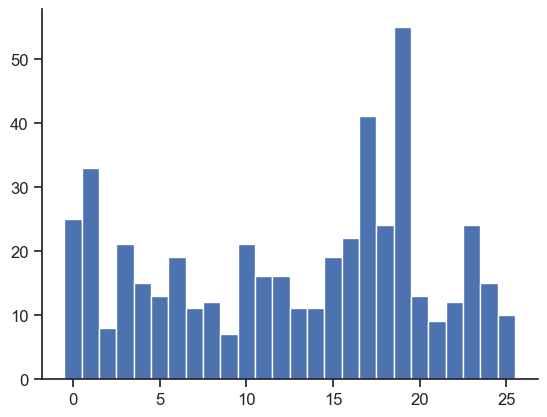

In [167]:
idx = sacc.groupby(['unitNumber','Session'])['r2_partial'].idxmax().to_numpy()
counts, bin_edges = np.histogram(idx, bins=np.arange(-0.5,26))
rank = np.argsort(counts)
print(candidate_vars[rank])
plt.close('all')
plt.hist(idx,bins=np.arange(-0.5,26))

['Node 11' 'Node 2' 'Node 10' 'up' '15 to 0' 'Node 7' 'tele' 'Node 5'
 'Node 4' 'Node 6' 'Node 8' 'NS' 'Node 14' '0 to 15' 'tele_dir' 'Node 15'
 'Node 13' 'Node 9' 'WE' 'Node 0' 'Node 1' 'left' 'Node 3' 'Node 12'
 'right' 'down']


(array([20., 23., 11., 25., 15., 15., 15., 15., 16., 18., 11., 10., 25.,
        18., 16., 17., 24., 37., 14., 40., 17., 14., 16., 19., 17., 15.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5]),
 <BarContainer object of 26 artists>)

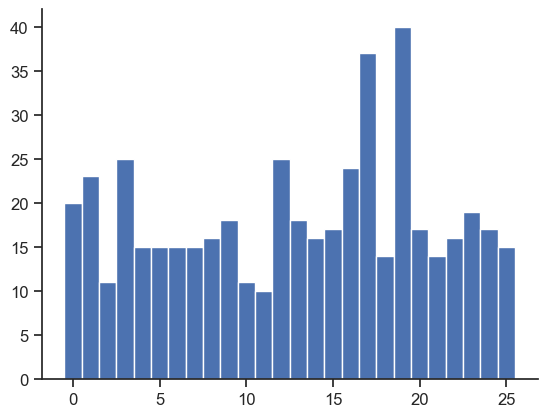

In [169]:
idx = presacc.groupby(['unitNumber','Session'])['r2_partial'].idxmax().to_numpy()
counts, bin_edges = np.histogram(idx, bins=np.arange(-0.5,26))
rank = np.argsort(counts)
print(candidate_vars[rank])
plt.close('all')
plt.hist(idx,bins=np.arange(-0.5,26))

['Node 2' '15 to 0' 'Node 5' 'Node 8' 'Node 7' '0 to 15' 'tele_dir'
 'Node 9' 'Node 10' 'Node 11' 'Node 13' 'tele' 'Node 3' 'NS' 'Node 4' 'WE'
 'Node 6' 'Node 15' 'Node 14' 'Node 12' 'up' 'left' 'Node 1' 'Node 0'
 'right' 'down']


(array([33., 29.,  8., 17., 18.,  9., 19., 10., 10., 12., 13., 13., 26.,
        13., 22., 20., 26., 34., 26., 44., 11.,  9., 17., 18., 11., 15.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5]),
 <BarContainer object of 26 artists>)

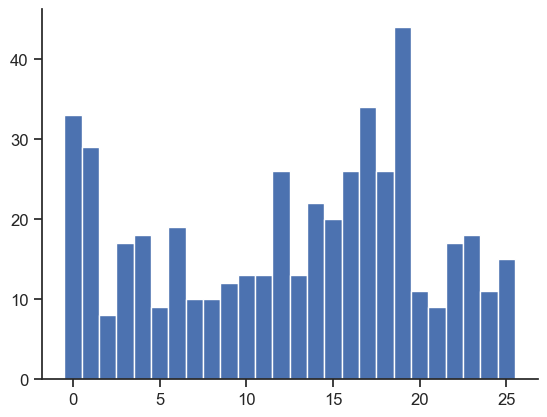

In [171]:
idx = postsacc.groupby(['unitNumber','Session'])['r2_partial'].idxmax().to_numpy()
counts, bin_edges = np.histogram(idx, bins=np.arange(-0.5,26))
rank = np.argsort(counts)
print(candidate_vars[rank])
plt.close('all')
plt.hist(idx,bins=np.arange(-0.5,26))

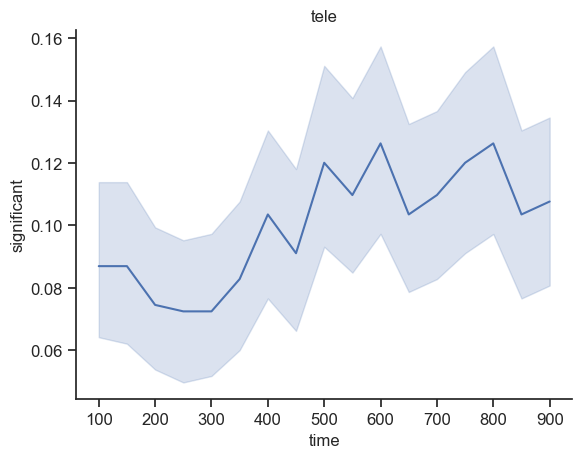

In [216]:
for var in candidate_vars:
    plt.close('all')
    sns.lineplot(data = results_df[results_df.variable==var],x='time',y='significant')
    plt.title(var)
    plt.savefig(var+' CPD significant')

In [146]:
def partial_r2_and_f(X_full, X_reduced, y):
    """
    Compute partial R^2 and F-test p-value for baseline vs baseline+additional_var.
    additional_var is a single column name (string).
    """
    y = np.asarray(y).ravel()
    n = len(y)

    # X_reduced = X[baseline_vars]
    # X_full = X[baseline_vars + additional_var]

    lm_r = LinearRegression().fit(X_reduced, y)
    yhat_r = lm_r.predict(X_reduced)
    ssr_r = np.sum((y - yhat_r) ** 2)
    r2_r = r2_score(y, yhat_r)

    lm_f = LinearRegression().fit(X_full, y)
    yhat_f = lm_f.predict(X_full)
    ssr_f = np.sum((y - yhat_f) ** 2)
    r2_f = r2_score(y, yhat_f)

    r2_partial = (r2_f - r2_r) / (1 - r2_r)

    df1 = X_full.shape[1]-X_reduced.shape[1]  # number of additional predictor
    df2 = n - X_full.shape[1] - 1
    f_stat = ((ssr_r - ssr_f) / df1) / (ssr_f / df2)
    pval = 1 - f.cdf(f_stat, df1, df2)

    return {"r2_partial": r2_partial, "r2_full": r2_f, "r2_reduced": r2_r,
            "f_stat": f_stat, "pval_f": pval}


In [199]:
def lasso_permutation_test(X, y, n_permutations=1000, random_state=42, alphas=None):
    """
    Test predictor significance in LASSO using permutation testing.
    
    Parameters
    ----------
    X : array-like (n_samples, n_features)
        Predictor matrix.
    y : array-like (n_samples,)
        Response vector.
    n_permutations : int, optional
        Number of permutations to run (default=1000).
    random_state : int, optional
        Random seed.
    alphas : list or None
        Candidate alpha values for LassoCV. If None, defaults to sklearn's grid.
    
    Returns
    -------
    results : pd.DataFrame
        DataFrame with real coefficients, mean permuted coefficients, 
        and p-values for each predictor.
    model : fitted LassoCV model
        The fitted Lasso model on the original data.
    """
    rng = np.random.default_rng(random_state)

    # Fit real model
    model = LassoCV(cv=10, alphas=alphas, random_state=random_state,selection='random').fit(X, y)
    real_coefs = model.coef_

    # Store permuted coefficients
    perm_coefs = np.zeros((n_permutations, X.shape[1]))

    for i in range(n_permutations):
        y_perm = shuffle(y, random_state=rng.integers(1e9))
        perm_model = LassoCV(cv=10, alphas=alphas, random_state=random_state).fit(X, y_perm)
        perm_coefs[i, :] = perm_model.coef_

    # Compute p-values (one-sided: how often permuted coef >= real coef in abs value)
    pvals = np.mean(np.abs(perm_coefs) >= np.abs(real_coefs), axis=0)

    results = pd.DataFrame({
        "coef": real_coefs,
        "perm_mean": perm_coefs.mean(axis=0),
        "pval": pvals
    })

    return results, model

In [188]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,"HPC","action_on","(trialerror == 0) ")
choice_df["action"] = choice_df.apply(lambda row: get_action(row['prenode'],row['node']), axis=1)
choice_df['distance'] = choice_df['graph_distance']
choice_df.loc[choice_df.distance>3,'distance'] = 4
choice_df['alltarget'] = np.isin(choice_df['node'].values,[1,7,8,14])

Bart_TeleWorld_v13_031723.nwb
Building Spike Table


1499it [00:01, 1296.85it/s]


Bart_TeleWorld_v13_032823.nwb
Building Spike Table


1860it [00:01, 1261.71it/s]


Bart_TeleWorld_v13_033123.nwb
Building Spike Table


2067it [00:01, 1411.18it/s]


Bart_TeleWorld_v13_032023.nwb
Building Spike Table


2278it [00:01, 1404.58it/s]


Bart_TeleWorld_v13_040423.nwb
Building Spike Table


2452it [00:01, 1268.32it/s]


Bart_TeleWorld_v13_040723.nwb
Building Spike Table


2093it [00:01, 1562.47it/s]


In [124]:
def create_balanced_datasets(df,FR,var1,trialNum=200):
    
    bstrap_df = pd.DataFrame()
    bstrap_spikes = []
    
    for var1_ind,val1 in enumerate(np.unique(df[var1])):  

        condition_idx = df[var1]==val1
        temp_df = df.loc[condition_idx,:].reset_index(drop=True)  
        temp_FR = FR[condition_idx,:,:]

        if len(temp_df)>0:
            
            idx = np.random.randint(len(temp_df),size=trialNum)
            bstrap_df = pd.concat([bstrap_df,temp_df.loc[idx,:]])
            bstrap_spikes.append(temp_FR[idx,:,:])

    return bstrap_df, np.concatenate(bstrap_spikes)

In [ ]:
do this for 1st step and all steps, for each model, get variance explained?

In [ ]:
# 1. calculate the VIF

all_vifs = []

for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):
    print(ss, date)
    
    ses = choice_df.query("Session == @date")
    FR = choice_spikes[ss]
    
    one_hot_node = to_one_hot(ses['node'].values)
    one_hot_action = to_one_hot(ses['action'].values)[:, 1:]
    
    # Build the 4 design matrices
    X_models = [
        # model 1
        np.concatenate([ses['distance'].values.reshape(-1,1),
                        one_hot_node], axis=1),

        # model 2
        np.concatenate([ses['distance'].values.reshape(-1,1),
                        one_hot_node, one_hot_action], axis=1),

        # model 3
        np.concatenate([ses['distance'].values.reshape(-1,1),
                        one_hot_node[:, ~np.isin(np.arange(16), [1,7,8,14])],
                        one_hot_action, ses['alltarget'].values.reshape(-1,1)], axis=1)
    ]
    
    # Compute VIF for each model
    for m, X in enumerate(X_models, start=1):
        X_df = pd.DataFrame(X)
        vifs = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
        all_vifs.append(pd.DataFrame({
            'session': date,
            'model': m,
            'feature': X_df.columns,
            'VIF': vifs
        }))

# Combine all results
vif_data = pd.concat(all_vifs, ignore_index=True)

# optional: quickly view mean VIF per model
vif_mean = vif_data.groupby(['model','feature'])['VIF'].mean().reset_index()
print(vif_mean.query('model==4'))


In [ ]:
scaler = StandardScaler()

In [86]:
from scipy.stats import f as f_dist

In [153]:
# regression analysis with partial F-test, DON'T CHANGE THIS!!!

# regressors to build: 1) distance/value, 
#                      2) node as one hop vector, 


pval=[]
coef=[]
r2=[]
p_node=[]
proportion_node=[]
fav_current_df=pd.DataFrame()
dis_df=pd.DataFrame()
timestamps = np.arange(100,950,50)
scaler = StandardScaler()

# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):

    print(ss,date)

    unitNames = neuron_df.query("Session==@date").unitNumber.values
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]
    X,_ = get_design_matrices(ses,1)

    coef_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
    pval_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
    p_node_temp = np.ones((FR.shape[2],len(timestamps)))*np.nan
    proportion_node_temp = np.zeros((FR.shape[2],len(timestamps)))
    r2_temp = np.ones((FR.shape[2],len(timestamps)))

    
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model

            y = FR[:,tt-100:tt+100,nn].sum(axis=1).reshape(-1,1)
            y = scaler.fit_transform(y)
        
            model = sm.OLS(y,X)
            res = model.fit()
            
            coef_temp[nn,ii,:] = res.params
            pval_temp[nn,ii,:] = res.pvalues
            r2_temp[nn,ii] = res.rsquared
            
            cpd = partial_r2_and_f(X, np.concatenate([ses['distance'].values.reshape(-1,1)],axis=1), y)
            p_node_temp[nn,ii] = cpd['pval_f']

######## should account for multiple fav states
    

    coef.append(coef_temp)
    pval.append(pval_temp)
    p_node.append(p_node_temp)
    r2.append(r2_temp)
    # proportion_node.append(proportion_current_temp)
    
coef = np.concatenate(coef)
pval = np.concatenate(pval)
p_node = np.concatenate(p_node)
r2 = np.concatenate(r2)

pval=pval[:,:,np.mean(~np.isnan(pval),axis=(0,1))>0]
proportion = np.mean(pval<0.05,axis=0)
proportion_node = np.mean(p_node<0.05,axis=0)

0 031723


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 18.42it/s]


1 032823


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.47it/s]


2 033123


100%|███████████████████████████████████████████| 88/88 [00:07<00:00, 11.82it/s]


3 032023


100%|███████████████████████████████████████████| 73/73 [00:06<00:00, 10.59it/s]


4 040423


100%|███████████████████████████████████████████| 88/88 [00:08<00:00, 10.51it/s]


5 040723


100%|███████████████████████████████████████████| 60/60 [00:05<00:00, 10.77it/s]


In [248]:
def get_design_matrices(ses,model):

    one_hot_node = to_one_hot(ses['node'].values)
    one_hot_action = to_one_hot(ses['action'].values)[:, 1:]

    # model 1
    if model==0:
        values = np.concatenate([ses['distance'].values.reshape(-1,1),
                         one_hot_node], axis=1)
        names =  {'distance':[0],
          'node':list(range(1,1+one_hot_node.shape[1]))}

    # # model 2
    # if model==1:
    #     values = np.concatenate([ses['distance'].values.reshape(-1,1),
    #                      one_hot_node, one_hot_action], axis=1)
    #     names = {'distance':[0],
    #       'node':list(range(1,1+one_hot_node.shape[1])),
    #       'action':list(range(1+one_hot_node.shape[1],
    #                           1+one_hot_node.shape[1]+one_hot_action.shape[1]))}


    # Tried following models, didn't really
    # # model 3
    # if model==2:
    #     values = np.concatenate([ses['distance'].values.reshape(-1,1),
    #                      one_hot_node[:, ~np.isin(np.arange(16), [1,7,8,14])],
    #                      one_hot_action, ses['alltarget'].values.reshape(-1,1)], axis=1)
    #     names = {'distance':[0],
    #       'node':list(range(1, 1+one_hot_node.shape[1]-4)),  # removed 4 nodes
    #       'action':list(range(1+one_hot_node.shape[1]-4,
    #                           1+one_hot_node.shape[1]-4+one_hot_action.shape[1])),
    #       'alltarget':[1+one_hot_node.shape[1]-4+one_hot_action.shape[1]]}

    # # model 4
    # if model==3:
    #     values = np.concatenate([ses['distance'].values.reshape(-1,1),
    #                      one_hot_node[:, ~np.isin(np.arange(16), [1,7,8,14])],
    #                      ses['alltarget'].values.reshape(-1,1)], axis=1)
    #     names = {'distance':[0],
    #       'node':list(range(1, 1+one_hot_node.shape[1]-4)),  # removed 4 nodes
    #       'alltarget':[1+one_hot_node.shape[1]-4]}
    
    return values, names

    # model 1, including distance and node as one hop vector
    # X = np.concatenate([ses['distance'].values.reshape(-1,1),one_hop_node],axis=1)

    # model 2, only include distance, should do it separately for each target to see if it is generic value or target specific
    # X = add_constant(ses['distance'].values)

    # model 3, add target as a one hop vector, this might get collinear with distance??

    # model 4, including distance and node, except combining four targets into one, 
    
    # X = np.concatenate([ses['distance'].values.reshape(-1,1),one_hop_node,
    #                    NS,WE,tele_dir,tele],axis=1)
    

In [278]:
# compare r2 from different models

# test_models = [0,1]

# r2_all = [[] for i in range(len(test_models))]
# coef_all = [[] for i in range(len(test_models))]
# pval_all = [[] for i in range(len(test_models))]
# p_node_all = [[] for i in range(len(test_models))]

timestamps = np.arange(100,950,50)
scaler = StandardScaler()

# ['031723','032823','033123','032023','040423','040723']

for mm in [1]: #enumerate(test_models):

    pval=[]
    coef=[]
    r2=[]
    p_node=[]
    p_action = []

    for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):
    
        print(ss,date)
    
        unitNames = neuron_df.query("Session==@date").unitNumber.values
        ses = choice_df.query("Session==@date")
        FR = choice_spikes[ss]
        X, predictors = get_design_matrices(ses,mm)
    
        coef_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
        pval_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
        p_node_temp = np.ones((FR.shape[2],len(timestamps)))*np.nan
        p_action_temp = np.ones((FR.shape[2],len(timestamps)))*np.nan
        proportion_node_temp = np.zeros((FR.shape[2],len(timestamps)))
        r2_temp = np.ones((FR.shape[2],len(timestamps)))
    
        
        for nn in tqdm(range(FR.shape[2])):
                    
            for ii, tt in enumerate(timestamps):
            
                # Fit the model
    
                y = FR[:,tt-100:tt+100,nn].sum(axis=1).reshape(-1,1)
                y = scaler.fit_transform(y)
            
                model = sm.OLS(y,X)
                res = model.fit()
                
                coef_temp[nn,ii,:] = res.params
                pval_temp[nn,ii,:] = res.pvalues
                r2_temp[nn,ii] = res.rsquared
                
                cpd = partial_r2_and_f(X, np.delete(X, predictors['node'], axis=1), y)
                p_node_temp[nn,ii] = cpd['pval_f']

                cpd = partial_r2_and_f(X, np.delete(X, predictors['action'], axis=1), y)
                p_action_temp[nn,ii] = cpd['pval_f']
        
    ######## should account for multiple fav states
        
    
        coef.append(coef_temp)
        pval.append(pval_temp)
        p_node.append(p_node_temp)
        p_action.append(p_action_temp)
        r2.append(r2_temp)
        # proportion_node.append(proportion_current_temp)
        
    coef_all[mm] = np.concatenate(coef)
    pval_all[mm] = np.concatenate(pval)
    p_node_all[mm] = np.concatenate(p_node)
    p_action_all[mm] = np.concatenate(p_action)
    r2_all[mm] = np.concatenate(r2)
    
    # pval=pval[:,:,np.mean(~np.isnan(pval),axis=(0,1))>0]
    # proportion = np.mean(pval<0.05,axis=0)
    # proportion_node = np.mean(p_node<0.05,axis=0)

    
    

0 031723


100%|███████████████████████████████████████████| 80/80 [00:32<00:00,  2.50it/s]


1 032823


100%|███████████████████████████████████████████| 94/94 [00:33<00:00,  2.81it/s]


2 033123


100%|███████████████████████████████████████████| 88/88 [00:29<00:00,  3.03it/s]


3 032023


100%|███████████████████████████████████████████| 73/73 [00:24<00:00,  2.97it/s]


4 040423


100%|███████████████████████████████████████████| 88/88 [00:54<00:00,  1.60it/s]


5 040723


100%|███████████████████████████████████████████| 60/60 [00:16<00:00,  3.71it/s]


NameError: name 'p_action_all' is not defined

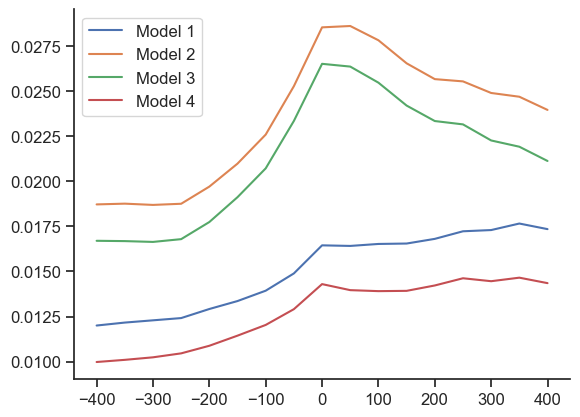

In [282]:
plt.close('all')
plt.plot(timestamps-500,r2_all[0].mean(axis=0),label='Model 1')
plt.plot(timestamps-500,r2_all[1].mean(axis=0),label='Model 2')
plt.plot(timestamps-500,r2_all[2].mean(axis=0),label='Model 3')
plt.plot(timestamps-500,r2_all[3].mean(axis=0),label='Model 4')
plt.legend()

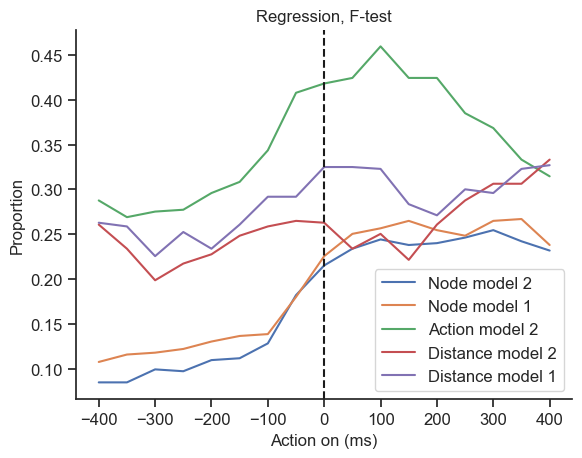

In [298]:
plt.close('all')
plt.plot(timestamps-500,np.mean(p_node_all[1]<0.05,axis=0),label='Node model 2')
plt.plot(timestamps-500,np.mean(p_node_all[0]<0.05,axis=0),label='Node model 1')
plt.plot(timestamps-500,np.mean(np.concatenate(p_action)<0.05,axis=0),label='Action model 2')
plt.plot(timestamps-500,np.mean(pval_all[1][:,:,0]<0.05,axis=0),label='Distance model 2')
plt.plot(timestamps-500,np.mean(pval_all[0][:,:,0]<0.05,axis=0),label='Distance model 1')

plt.axvline(0,color='k',ls='--')
plt.title('Regression, F-test')
plt.ylabel('Proportion')
plt.xlabel('Action on (ms)')
plt.legend()

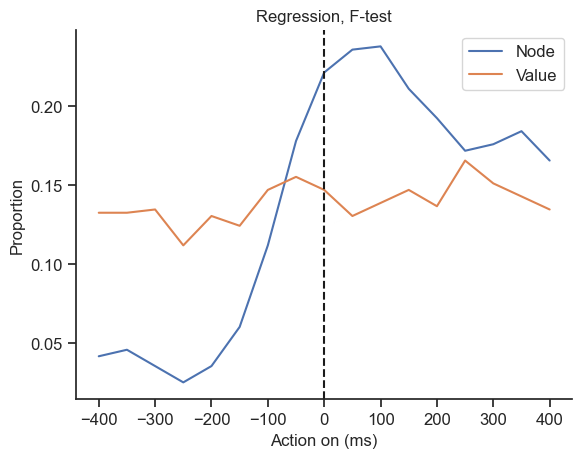

In [155]:
plt.close('all')
plt.plot(timestamps-500,proportion_node,label='Node')
plt.plot(timestamps-500,proportion[:,0],label='Value')
plt.axvline(0,color='k',ls='--')
plt.title('Regression, F-test')
plt.ylabel('Proportion')
plt.xlabel('Action on (ms)')
plt.legend()

In [116]:
# Collect results

r2_all = []
pvals_all = []
timestamps = np.arange(100,950,50)

# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723']):
    
    print(ss, date)

    ses = choice_df.query("Session == @date")
    FR = choice_spikes[ss]

    models = get_design_matrices(ses)

    for m_idx, (X, var_groups) in enumerate(models, start=1):
        
        X = X.astype(float)

        n_neurons = FR.shape[2]
        n_time = len(timestamps)

        r2 = np.zeros((n_neurons, n_time))
        pvals = np.full((n_neurons, n_time, X.shape[1]), np.nan)

        # CPD for each variable group
        cpd_results = {}
        ftest_results = {}

        for nn in tqdm(range(n_neurons), desc=f"session {date}, model {m_idx}"):
            for ii, tt in enumerate(timestamps):
                
                y = FR[:, tt-100:tt+100, nn].sum(axis=1).reshape(-1,1)
                y = scaler.fit_transform(y)

                # fit full mode and reduced model

                full = sm.OLS(y, X).fit()
        
                for varname, cols in var_groups.items():
                    
                    # CPD: drop these cols, compare RSS
                    X_reduced = np.delete(X, cols, axis=1)
                    ss_full = np.zeros((n_neurons, n_time))
                    ss_red = np.zeros((n_neurons, n_time))
        
                    fvals = np.zeros((n_neurons, n_time))
                    pvals_ftest = np.zeros((n_neurons, n_time))
                
                    k_f = X.shape[1]
                    k_r = X_reduced.shape[1]

                    red = sm.OLS(y, X_reduced).fit()
    
                    r2[nn, ii] = full.rsquared
                    pvals[nn, ii, :] = full.pvalues
                    
                    RSS_f = np.sum((y - full.fittedvalues)**2)
                    RSS_r = np.sum((y - red.fittedvalues)**2)
                    df_f = y.shape[0] - k_f
                    df_r = y.shape[0] - k_r
        
                    # CPD
                    ss_full[nn,ii] = RSS_f
                    ss_red[nn,ii] = RSS_r
        
                    # Partial F
                    F = ((RSS_r - RSS_f) / (k_f - k_r)) / (RSS_f / df_f)
                    p = 1 - f_dist.cdf(F, k_f - k_r, df_f)
        
                    fvals[nn,ii] = F
                    pvals_ftest[nn,ii] = p
        
            cpd = (ss_red - ss_full) / ss_red
            cpd_results[varname] = cpd
            ftest_results[varname] = pvals_ftest  

        # Save summary
        results.append({
            'session': date,
            'model': m_idx,
            'mean_r2': mean_r2,
            **{f'cpd_{k}': v for k,v in cpd_results.items()},
            **{f'ftest_sig_{k}': v for k,v in ftest_results.items()},
            **{f'prop_{k}': v for k,v in prop_sig.items()}
        })


0 031723


session 031723, model 1: 100%|██████████████████| 80/80 [00:39<00:00,  2.04it/s]


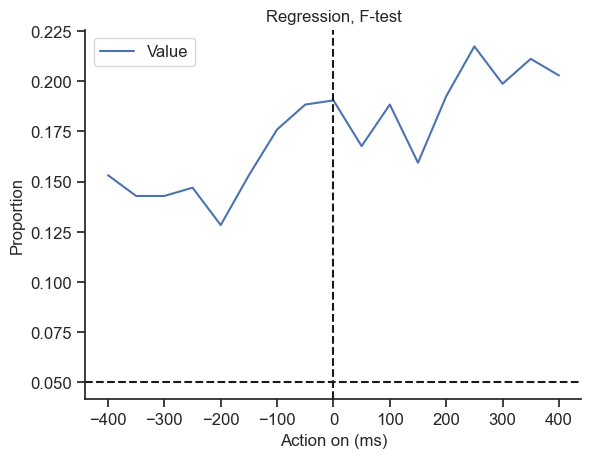

In [196]:
plt.close('all')
# plt.plot(timestamps-500,proportion_node,label='Node')
plt.plot(timestamps-500,proportion[:,1],label='Value')
plt.axhline(0.05,color='k',ls='--')
plt.axvline(0,color='k',ls='--')
plt.title('Regression, F-test')
plt.ylabel('Proportion')
plt.xlabel('Action on (ms)')
plt.legend()

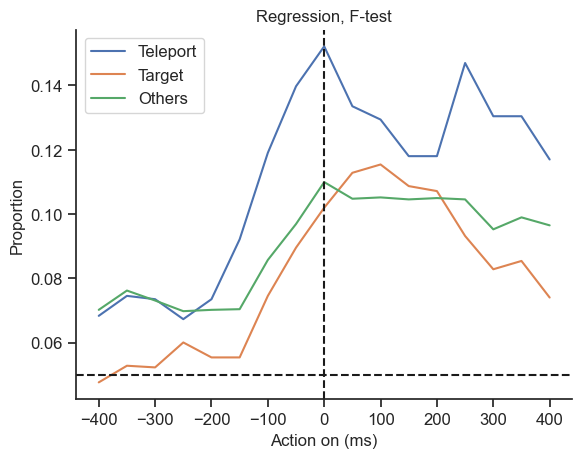

In [174]:
plt.close('all')
# plt.plot(timestamps-500,proportion_node,label='Node')
plt.plot(timestamps-500,proportion[:,1:][:,np.array([0,15])].mean(axis=1),label='Teleport')
plt.plot(timestamps-500,proportion[:,1:][:,np.array([1,7,8,14])].mean(axis=1),label='Target')
plt.plot(timestamps-500,proportion[:,1:][:,np.array([2,3,4,5,6,9,10,11,12,13])].mean(axis=1),label='Others')

plt.axvline(0,color='k',ls='--')
plt.axhline(0.05,color='k',ls='--')
plt.title('Regression, F-test')
plt.ylabel('Proportion')
plt.xlabel('Action on (ms)')
plt.legend()

In [90]:
# action, restrained the analysis on center nodes [5,6,9,10]

pval=[]
coef=[]

timestamps = np.arange(100,950,50)
scaler = StandardScaler()


for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']):

    print(ss,date)

    unitNames = neuron_df.query("Session==@date").unitNumber.values
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]

    one_hop_action = to_one_hot(ses['action'].values)[:,1:]
    
    idx = np.isin(ses['node'].values,[5,6,9,10])
    X = one_hop_action[idx,:4]
    FR = FR[idx,:,:]
    
    X = pd.DataFrame(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print('Variable with collinearity',np.sum(vif_data["VIF"].values>5))

    coef_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
    pval_temp = np.ones((FR.shape[2],len(timestamps),X.shape[1]))*np.nan
    
    for nn in tqdm(range(FR.shape[2])):
                
        for ii, tt in enumerate(timestamps):
        
            # Fit the model

            y = FR[:,tt-100:tt+100,nn].sum(axis=1).reshape(-1,1)
            scaler.fit(y)
            normed_y = scaler.transform(y)
        
            model = sm.OLS(normed_y,X)
            res = model.fit()
            
            coef_temp[nn,ii,:] = res.params
            pval_temp[nn,ii,:] = res.pvalues
    

    coef.append(coef_temp)
    pval.append(pval_temp)

coef = np.concatenate(coef)
pval = np.concatenate(pval)

pval=pval[:,:,np.mean(~np.isnan(pval),axis=(0,1))>0]
proportion = np.mean(pval<0.05,axis=0)

0 031723
Variable with collinearity 0


100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 72.45it/s]


1 032823
Variable with collinearity 0


100%|███████████████████████████████████████████| 94/94 [00:01<00:00, 61.02it/s]


2 033123
Variable with collinearity 0


100%|███████████████████████████████████████████| 88/88 [00:02<00:00, 42.36it/s]


3 032023
Variable with collinearity 0


100%|███████████████████████████████████████████| 73/73 [00:01<00:00, 46.66it/s]


4 040423
Variable with collinearity 0


100%|███████████████████████████████████████████| 88/88 [00:01<00:00, 60.36it/s]


5 040723
Variable with collinearity 0


100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 60.60it/s]


In [24]:
choice_df, choice_spikes, neuron_df = combine_data(DATA_DIR,"HPC","action_on","(trialerror == 0)")
choice_df["action"] = choice_df.apply(lambda row: get_action(row['prenode'],row['node']), axis=1)
choice_df['distance'] = choice_df['graph_distance']
choice_df.loc[choice_df.distance>2,'distance'] = 3
choice_df['alltarget'] = np.isin(choice_df['node'].values,[1,7,8,14])
choice_df['istarget'] = choice_df['node']==choice_df['target']

Bart_TeleWorld_v13_031723.nwb
Building Spike Table


1499it [00:01, 996.71it/s] 


Bart_TeleWorld_v13_032823.nwb
Building Spike Table


1860it [00:01, 1225.21it/s]


Bart_TeleWorld_v13_033123.nwb
Building Spike Table


2067it [00:01, 1449.04it/s]


Bart_TeleWorld_v13_032023.nwb
Building Spike Table


2278it [00:01, 1286.82it/s]


Bart_TeleWorld_v13_040423.nwb
Building Spike Table


2452it [00:02, 1167.63it/s]


Bart_TeleWorld_v13_040723.nwb
Building Spike Table


2093it [00:01, 1230.35it/s]


In [52]:
sz1 = 18
sz2 = 24
sns.set(style="ticks", rc={"lines.linewidth": 2})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

0 031723


80it [03:36,  2.71s/it]


1 032823


94it [03:21,  2.14s/it]


2 033123


88it [01:54,  1.30s/it]


3 032023


73it [01:36,  1.33s/it]


4 040423


88it [02:12,  1.50s/it]


5 040723


60it [01:11,  1.19s/it]


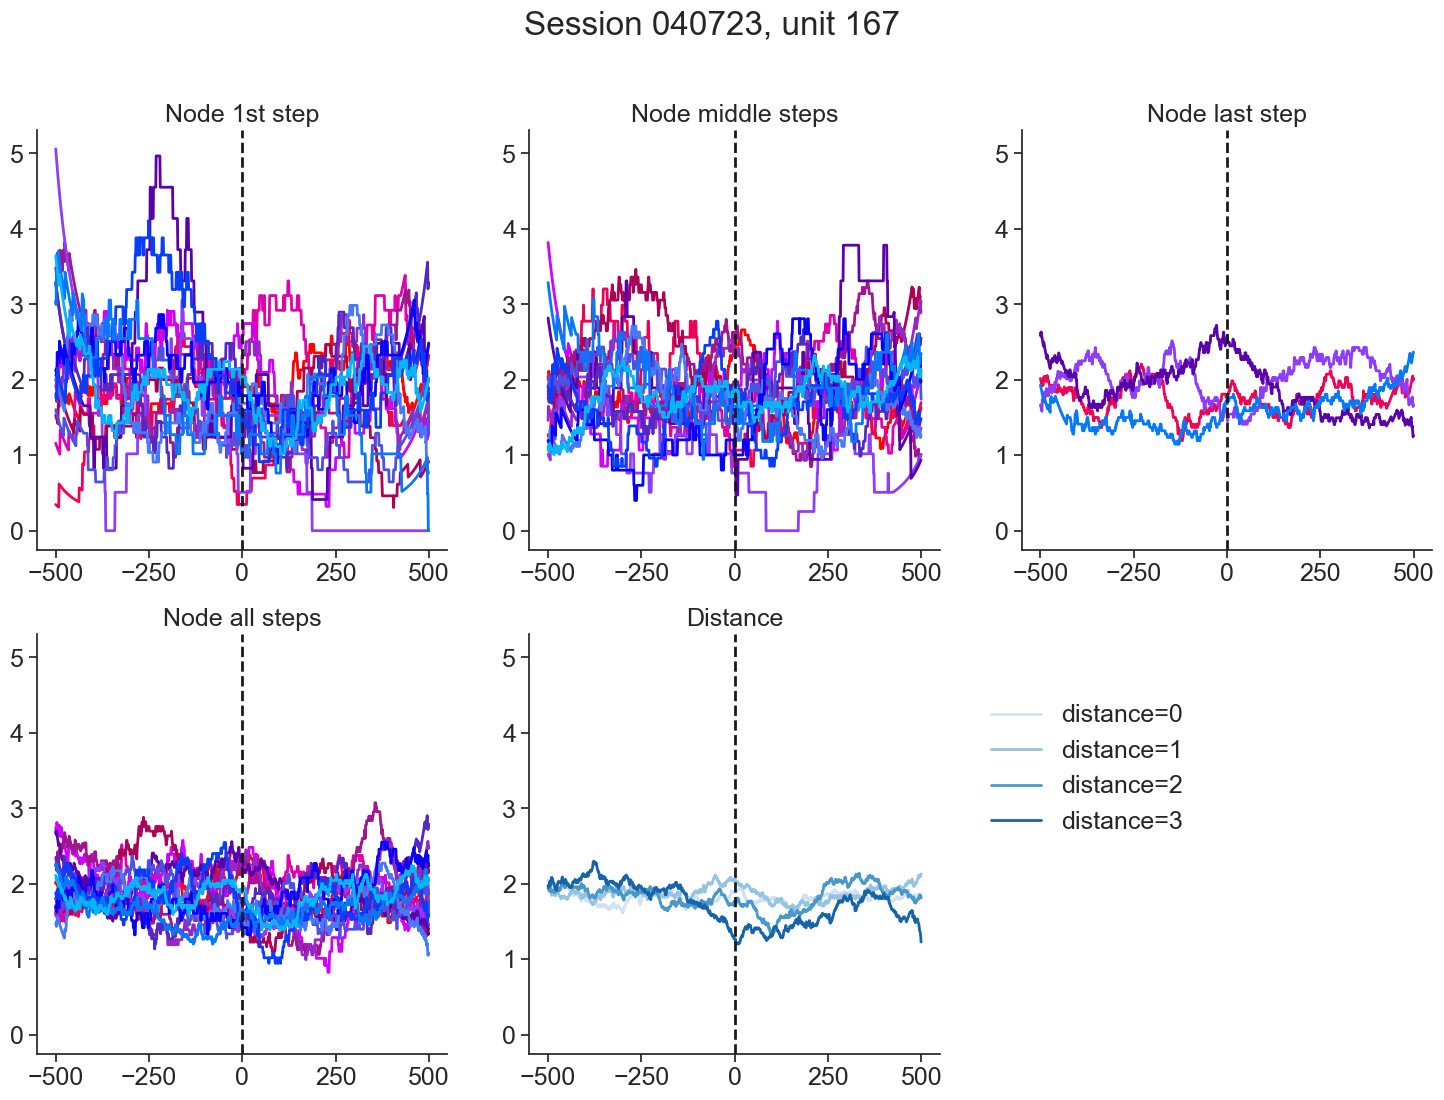

In [80]:
# for each neuron, look at tuning to node at 1st step, node at all steps, distance

# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']): 

    print(ss,date)
    
    unitNames = neuron_df.query("Session==@date").unitNumber.values
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]

    for nn, unitNumber in tqdm(enumerate(unitNames)):

        plt.close('all')
        
        fig, axes = plt.subplots(2,3,figsize=(18,12))

        idx = ses.step.values==0
        plot_psth(FR[idx,:,nn], ses.iloc[idx,:], 'node', axes[0,0])
        axes[0,0].set_title('Node 1st step')

        idx = (ses.step.values>0) & (ses.step.values<ses.nsteps.values)
        plot_psth(FR[idx,:,nn], ses.iloc[idx,:], 'node', axes[0,1])
        axes[0,1].set_title('Node middle steps')

        idx = ses.step.values==ses.nsteps.values
        plot_psth(FR[idx,:,nn], ses.iloc[idx,:], 'node', axes[0,2])
        axes[0,2].set_title('Node last step')
        
        plot_psth(FR[:,:,nn], ses, 'node', axes[1,0])
        axes[1,0].set_title('Node all steps')
        
        idx = (ses.distance.values>-1) & (ses.distance.values<4)
        plot_psth(FR[idx,:,nn], ses.iloc[idx,:], 'distance', axes[1,1])
        axes[1,1].legend(frameon=False,loc=(1.1,0.5))
        axes[1,1].set_title('Distance')

        axes[1,2].set_visible(False)

        all_axes = [axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1]]
    
        # get the min and max of all current y-limits
        ymins, ymaxs = zip(*[ax.get_ylim() for ax in all_axes])
        ymin, ymax = min(ymins), max(ymaxs)
        
        # set the same y-limit on all subplots
        for ax in all_axes:
            ax.set_ylim(ymin, ymax)

        plt.suptitle("Session %s, unit %i" % (date,unitNumber))
        plt.savefig("Session %s, unit %i" % (date,unitNumber))


0 031723


80it [00:38,  2.08it/s]


1 032823


94it [00:58,  1.60it/s]


2 033123


88it [00:47,  1.85it/s]


3 032023


73it [00:39,  1.87it/s]


4 040423


88it [00:59,  1.48it/s]


5 040723


60it [00:25,  2.37it/s]


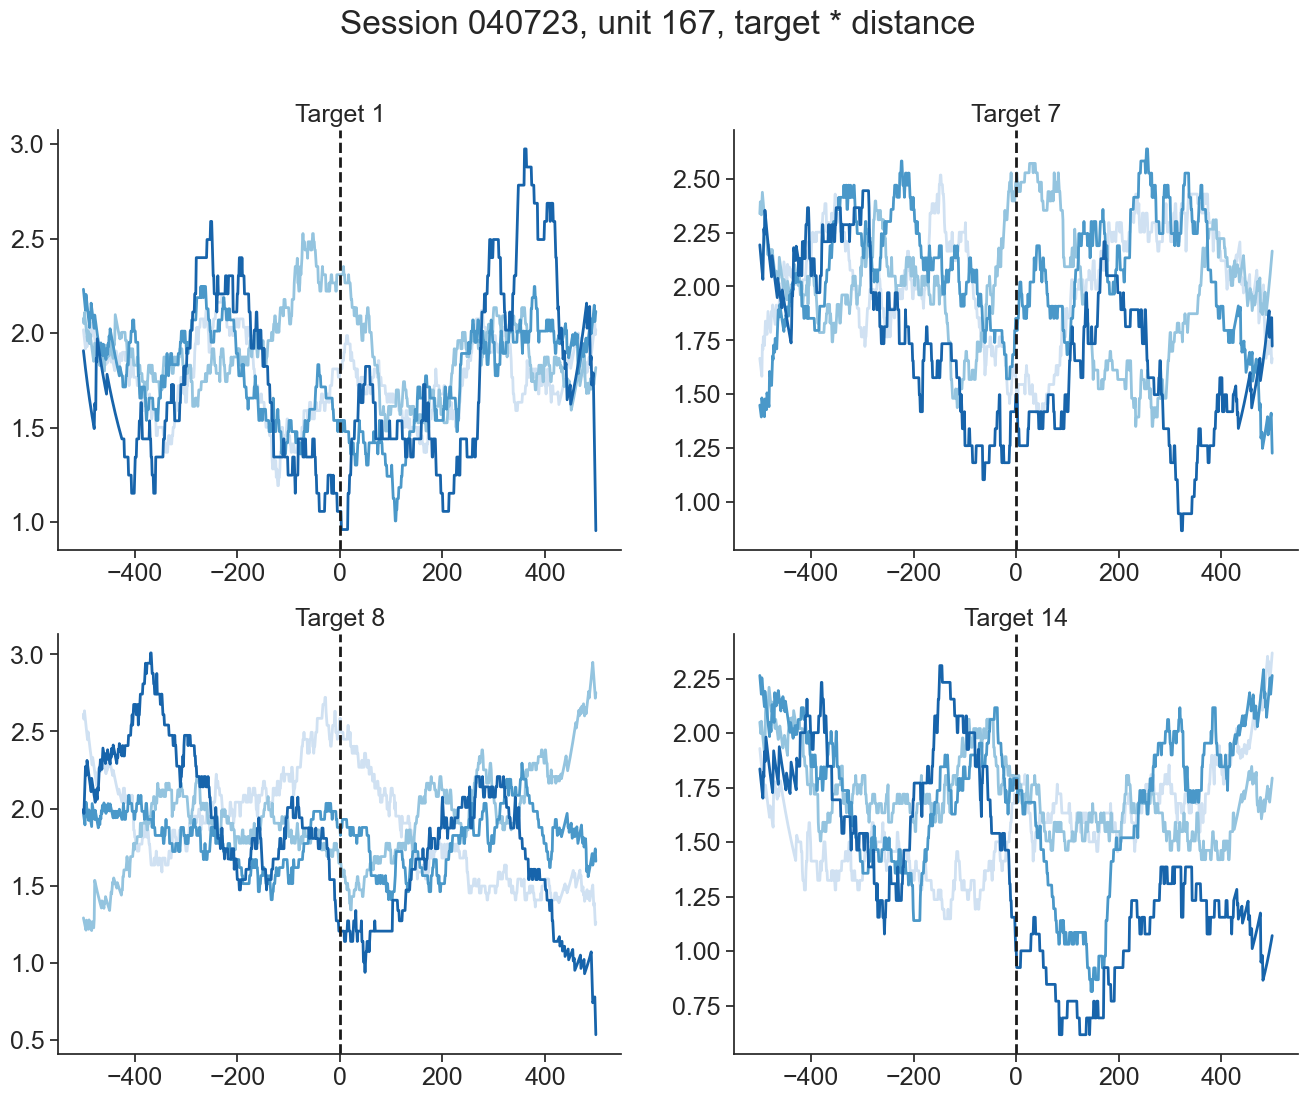

In [54]:
# for each neuron, look at distance * target conjunction

# ['031723','032823','033123','032023','040423','040723']

for ss, date in enumerate(['031723','032823','033123','032023','040423','040723']): 

    print(ss,date)
    
    unitNames = neuron_df.query("Session==@date").unitNumber.values
    ses = choice_df.query("Session==@date")
    FR = choice_spikes[ss]
    
    
    for nn, unitNumber in tqdm(enumerate(unitNames)):

        plt.close('all')
        
        fig, axes = plt.subplots(2,2,figsize=(16,12))

        for ii, target in enumerate([1,7,8,14]):

            idx = (ses.distance.values>-1) & (ses.distance.values<4) & (ses.target==target)
            plot_psth(FR[idx,:,nn], ses.loc[idx,:], 'distance', axes[np.divmod(ii,2)])
            axes[np.divmod(ii,2)].set_title("Target %i" % target)
            # axes[np.divmod(ii)].legend(loc=(0.5,-0.6))

            
        plt.suptitle("Session %s, unit %i, target * distance" % (date,unitNumber))
        plt.savefig("Session %s, unit %i, target and distance" % (date,unitNumber))


In [22]:
def plot_psth(spikes, df, condition, ax):

    uni_values = np.sort(df[condition].unique())
    t = np.arange(-500, 500)
    
    if condition=='distance':
        colors = sns.color_palette('Blues',len(uni_values))
    if condition=='action':
        colors = sns.color_palette("bright", len(uni_values)) 
    if condition=='target':
        colors = sns.color_palette("bright", len(uni_values)) 
        
    for ii, vv in enumerate(uni_values):
        
        idx = df[condition].values == vv
        trace = movmean(spikes[idx, :].mean(axis=0)*1000, w=75).flatten()
        
        if condition=='node':
            x,y=xy(vv,4,4)
            ax.plot(t, trace,color=cmap_2d[x,y],label = condition + '=' + str(vv))
        else:
            ax.plot(t, trace,color=colors[ii],label = condition + '=' + str(vv))
        
    ax.axvline(0, color='k', linestyle='--')


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df[["X1", "X2", "X3"]]  # predictors
y = df["y"]

# scale predictors (important for LASSO)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# cross-validated LASSO
lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)

print("Optimal alpha (penalty):", lasso.alpha_)
print("Coefficients:", dict(zip(X.columns, lasso.coef_)))

# keep predictors with non-zero coefficients
selected_predictors = [col for col, coef in zip(X.columns, lasso.coef_) if coef != 0]
print("Selected predictors:", selected_predictors)


In [19]:
data = np.load("/Users/lianghexin/Documents/Berkeley/Teleworld/Code/MI first step node 200.npy", allow_pickle=True).item()

# Now `data` is the dict you originally saved
MI         = data["MI"]
zscored_MI = data["zscored_MI"]
sparsity   = data["sparsity"]
Lambda     = data["Lambda"]
Lambda_i   = data["Lambda_i"]
null       = data["null"]
label      = data["label"]

criterion1 = MI > np.percentile(null, 95, axis=1)
criterion2 = Lambda > 0
criterion3 = MI > 0
sig = criterion1*criterion2*criterion3

(array([ 4.,  5.,  3.,  4.,  5.,  3.,  2., 34., 14.,  3.,  3.,  4.,  2.,
         4., 28.,  5.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5]),
 <BarContainer object of 16 artists>)

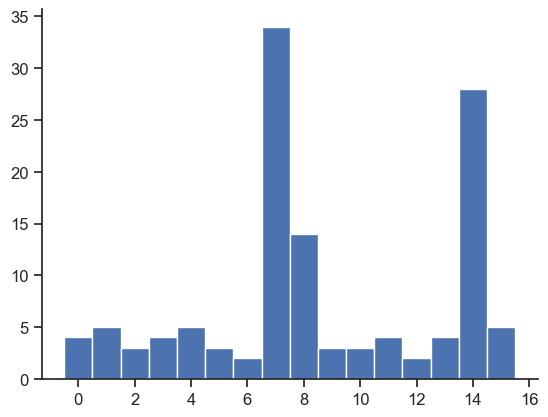

In [158]:
idx = (pval[:,9,-3]>0.05) & (sig[:,9])
fav_node = np.argmax(Lambda_i[idx,9,:],axis=1)
plt.hist(fav_node,bins=np.arange(-0.5,16))

In [172]:
# add regression results to neuron_df

neuron_df["reg_coef"] = list(coef) 
neuron_df["reg_pval"] = list(pval)

ts = np.argmax(proportion[:,-3])
neuron_df["reward"] = pval[:,ts,-3]<0.05

ts = np.argmax(proportion[:,-2])
neuron_df["target"] = pval[:,ts,-2]<0.05

ts = np.argmax(proportion[:,-1])
neuron_df["distance"] = pval[:,ts,-1]<0.05

ts = np.argmax(proportion_node)
neuron_df["spatial_reg"] = p_node[:,ts]<0.05

# add information measurements to neuron_df
neuron_df["MI"] = list(MI)         
neuron_df["zscored_MI"] = list(zscored_MI) 
neuron_df["sparsity"] = list(sparsity)   
neuron_df["Lambda"] = list(Lambda)     
neuron_df["Lambda_i"] = list(Lambda_i)   

ts = np.argmax(sig.mean(axis=0))
neuron_df["spatial"] = sig[:,ts]
neuron_df["fav_node"] = np.argmax(Lambda_i[:,ts,:],axis=1)


In [174]:
neuron_df.to_hdf("SingleNeurons.h5",key='data')

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_44470/2666198969.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['Session', 'unitNames', 'region', 'subfield', 'group', 'waveform_mean',
       'reg_coef', 'reg_pval', 'MI', 'zscored_MI', 'sparsity', 'Lambda',
       'Lambda_i'],
      dtype='object')]

  neuron_df.to_hdf("SingleNeurons.h5",key='data')


In [269]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [287]:
neuron_df

,Session,unitNumber,unitNames,channelNumbers,unitOnChannel,probe,firingRate,date,region,ap,...,target_tuning,distance_tuning,MI,zscored_MI,sparsity,Lambda,Lambda_i,node_tuning,node_tuning_reg,fav_node
0,031723,97,S01_SPK099_002,99,2,4,1.258591,31723,HPC,17.4,...,False,False,"[0.4342260320815474, 0.4121338026077264, 0.409...","[-0.5126923965869727, -0.4787608637491605, -0....","[0.6283967412409144, 0.6445695318840564, 0.680...","[0.3150406409986317, 0.28455283609218895, 0.28...","[[0.30000001192092896, 0.0, 0.1351351439952850...",False,True,8
1,031723,98,S01_SPK100_001,100,1,4,5.954936,31723,HPC,17.4,...,False,False,"[0.009420720761602445, 0.016360155519969444, 0...","[-0.9314701949428208, 0.3391910911138197, 0.22...","[0.6297978190755613, 0.7623663947088916, 0.825...","[6.036585196852684, 5.955284461379051, 6.03658...","[[6.599999904632568, 5.555555820465088, 5.2702...",True,True,8
2,031723,100,S01_SPK101_002,101,2,4,2.233587,31723,HPC,17.4,...,False,False,"[0.1360203713394035, 0.17374110527881512, 0.19...","[0.15235041748268202, 0.6744195297046185, 0.74...","[0.8552652296827409, 0.8280549677333185, 0.825...","[1.067073200829327, 0.9552845731377602, 0.9247...","[[1.0, 1.1111111640930176, 1.3513513803482056,...",False,True,15
3,031723,102,S01_SPK103_001,103,1,4,1.878908,31723,HPC,17.4,...,False,False,"[0.13663005803332007, 0.11296067735766593, 0.1...","[0.04232508973405336, -0.3386247224514554, -0....","[0.8556144057150936, 0.876225199485288, 0.8658...","[1.7581300344318151, 1.737804850563407, 1.7174...","[[2.700000047683716, 2.222222328186035, 2.7027...",False,False,13
4,031723,103,S01_SPK104_001,104,1,4,1.051078,31723,HPC,17.4,...,False,False,"[0.3512884761636854, 0.3900202950029069, 0.322...","[1.007864183010203, 2.226104201540475, 1.97874...","[0.716996428573659, 0.700459738796412, 0.72287...","[0.5589430802501738, 0.6504065240733325, 0.640...","[[0.7999999523162842, 0.5555555820465088, 0.40...",True,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,040723,163,S06_SPK189_001,189,1,6,3.042736,40723,HPC,12.1,...,False,False,"[0.03159215734918373, 0.031724951741011614, 0....","[0.08096522197879512, 0.09668826318704443, 1.2...","[0.75180526975626, 0.7997634127872219, 0.77472...","[3.0033558141440153, 2.9614095110446215, 3.053...","[[2.3728814125061035, 3.28947377204895, 2.9411...",False,False,7
479,040723,164,S06_SPK190_001,190,1,6,1.973397,40723,HPC,12.1,...,False,False,"[0.05537684116312217, 0.07451094092155049, 0.0...","[0.5243148935351726, 1.6521799524194694, 1.438...","[0.5872505103070847, 0.4551656440672153, 0.451...","[2.5083892978727818, 2.2734899539500475, 2.072...","[[2.3728814125061035, 2.6315791606903076, 2.79...",False,False,12
480,040723,165,S06_SPK191_001,191,1,6,4.693107,40723,HPC,12.1,...,False,False,"[0.023282447731757937, 0.021098751912608654, 0...","[-0.07518543720060412, -0.2916943811508833, 0....","[0.7689404166220668, 0.6295796404193251, 0.820...","[4.92449663579464, 4.823825322091579, 4.765100...","[[4.91525411605835, 3.28947377204895, 4.852941...",False,False,2
481,040723,166,S06_SPK192_001,192,1,6,1.514112,40723,HPC,12.1,...,False,False,"[0.08831376040210075, 0.0966768182496091, 0.07...","[-0.3976936554870922, -0.27330423813953036, -0...","[0.7136408383123732, 0.6267808223938092, 0.707...","[1.778523437678814, 1.803691266104579, 1.74496...","[[2.542372703552246, 0.9210526347160339, 1.470...",False,False,15


Text(0.5, 0, 'Node with maximum FR')

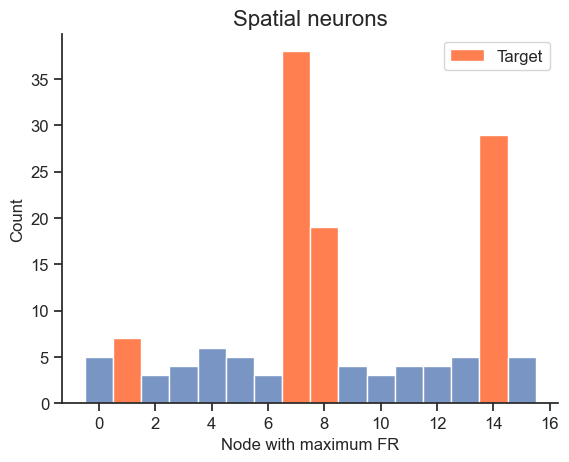

In [289]:
from matplotlib.patches import Patch

plt.close('all')

ax = sns.histplot(data=neuron_df[neuron_df.node_tuning],x='fav_node',bins=np.arange(-0.5,16,1))

# Target nodes to highlight
highlight = [1, 7, 8, 14]

# Paint specific bars coral
for patch in ax.patches:
    # Compute center of bar
    center = patch.get_x() + patch.get_width()/2
    if center in highlight:
        patch.set_facecolor("coral")

legend_elements = [
    Patch(facecolor='coral', label='Target'),
]

plt.legend(handles=legend_elements)
plt.title('Spatial neurons',fontsize=16)
plt.xlabel('Node with maximum FR')

In [ ]:
look at their target-dependent activation probability 

In [ ]:
this analysis was restrained at the first step, 
do these neurons fire because the target appears at the first step or not?

in other way, are they 'reward anticipating' or 'memory of target'?



In [144]:
sig_node = p_node[:,5]<0.05
sig_target = pval[:,7,-2]<0.05

Text(0.5, 0.98, 'Node and target from all steps')

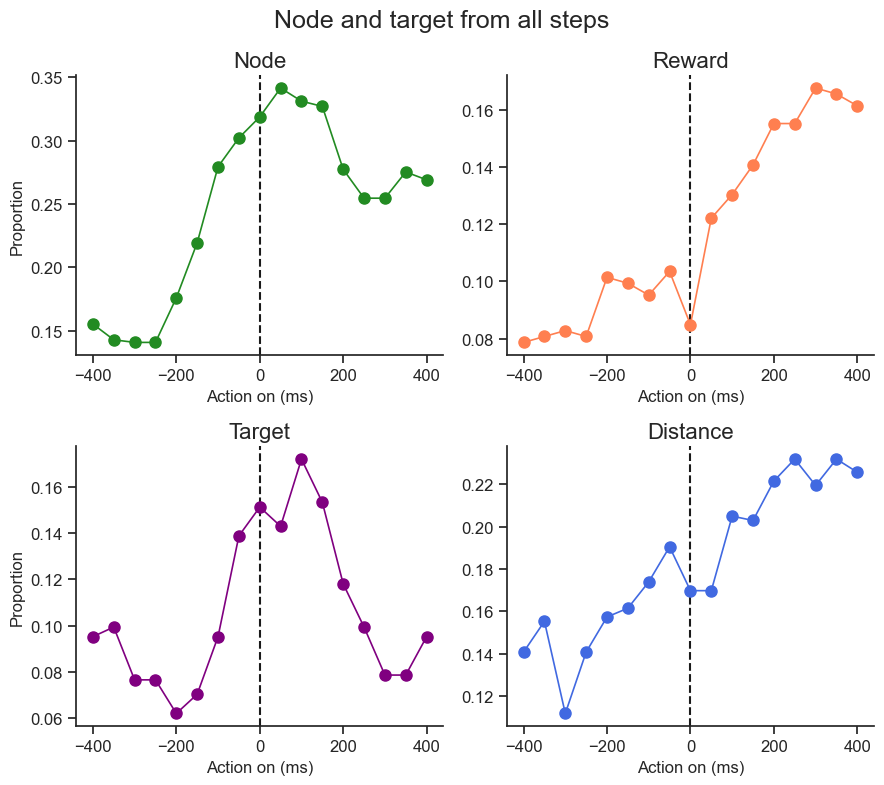

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8))  # 2x2 grid
axes = axes.flatten()  # make it easier to index

legends = ['Node', 'Reward', 'Target', 'Distance']
colors = ['forestgreen', 'coral','purple', 'royalblue']

# Your data
data_list = [proportion_node, proportion[:, -3], proportion[:, -2], proportion[:, -1]]

for ii in range(4):  
    ax = axes[ii]
    ax.plot(
        timestamps - 500,
        data_list[ii],
        color=colors[ii],
        lw=1.2,
        marker='o',
        ms=8,
        label=legends[ii],
        zorder=2
    )
    ax.set_title(legends[ii], fontsize=16)
    ax.axvline(0, color='k', ls='--', zorder=1)
    ax.set_xlabel("Action on (ms)")

# Y-label only on the first subplot
axes[0].set_ylabel("Proportion")
axes[2].set_ylabel("Proportion")


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Node and target from all steps')
# plt.savefig('regression model 3')


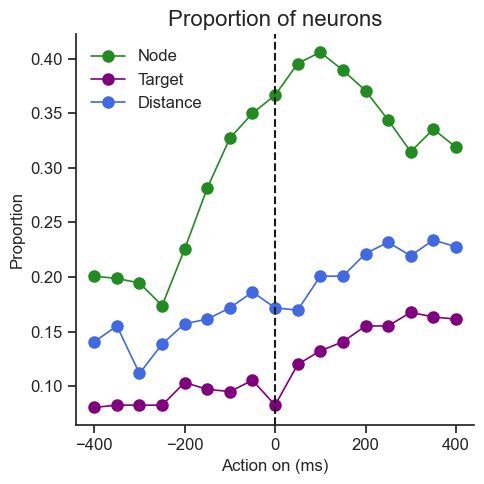

In [60]:
plt.close('all')
plt.figure(figsize=(5,5))

legends = ['Node', 'Target', 'Distance']
colors = ['forestgreen', 'purple', 'royalblue']

# Your three signals
data_list = [proportion_node, proportion[:, -2], proportion[:, -1]]

for ii in range(3):
    plt.plot(
        timestamps - 500,
        data_list[ii],
        color=colors[ii],
        lw=1.2,
        marker='o',
        ms=8,
        label=legends[ii],
        zorder=2
    )

plt.legend(frameon=False)
plt.xlabel("Action on (ms)")
plt.ylabel("Proportion")
plt.title("Proportion of neurons",zorder=1,fontsize=16)
plt.axvline(0,color='k',ls='--')
plt.tight_layout()
plt.show()
